In [62]:
!pip install ray

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch.nn as nn
from transformers import BertModel
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS
import json
import torch
import random
from ray.data.preprocessor import Preprocessor
#from ray.train.torch import get_device
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import BertTokenizer
import numpy as np
import os
import ray
import logging
from ray.train import get_context
logging.getLogger('ray').setLevel(logging.ERROR)

In [125]:
from ray.air import  session

from ray import train
from ray.train import  RunConfig, CheckpointConfig, ScalingConfig
from ray.train import get_context
from ray.train.torch import TorchCheckpoint, TorchTrainer
import torch.nn.functional as F

In [65]:
import ray
if ray.is_initialized():
    ray.shutdown()
ray.init(
    log_to_driver=False,
    _metrics_export_port=None
)
import sys
sys.path.append("..")

2026-01-11 00:46:55,653	INFO worker.py:2007 -- Started a local Ray instance.


In [66]:
ray.cluster_resources()

{'accelerator_type:L4': 1.0,
 'node:__internal_head__': 1.0,
 'CPU': 12.0,
 'memory': 39479778509.0,
 'node:172.28.0.12': 1.0,
 'object_store_memory': 16919905075.0,
 'GPU': 1.0}

In [67]:
num_workers = 1
resources_per_worker={"CPU": 1, "GPU": 1}

In [68]:
DATASET_LOC = os.path.join(os.getcwd(), 'reddit_posts_20251212_035106.parquet')

In [69]:
df = pd.read_parquet(DATASET_LOC)

In [70]:
df.head()

,post_id,title,subreddit
0,1pkhhxb,"Even the man behind ChatGPT, OpenAI CEO Sam Al...",technology
1,1pkh69t,"Palantir sues CEO of rival AI firm Percepta, a...",technology
2,1pkg053,'Architects of AI' named Time Magazine's Perso...,technology
3,1pkfqa0,Sam Altman expects OpenAI to exit ‘code red’ b...,technology
4,1pkfpmf,Broadcom reveals its mystery $10 billion custo...,technology


In [71]:
df['subreddit'].value_counts()

,count
subreddit,
entertainment,997
technology,989
science,987
politics,986
ArtificialInteligence,962


In [72]:
df = df.sample(frac = 1.0)

In [73]:
test_size = 0.2
train_df, val_df = train_test_split(df, test_size = test_size, stratify = df['subreddit'], random_state = 13)


In [74]:
train_df['subreddit'].value_counts()

,count
subreddit,
entertainment,797
technology,791
politics,789
science,789
ArtificialInteligence,770


In [75]:
(val_df['subreddit'].value_counts() * (1-test_size))/(test_size)

,count
subreddit,
entertainment,800.0
science,792.0
technology,792.0
politics,788.0
ArtificialInteligence,768.0


## EDA

Let us first visualise the number of examples per subreddit.

In [76]:
counter = Counter(df['subreddit'])
counter.most_common()

[('entertainment', 997),
 ('technology', 989),
 ('science', 987),
 ('politics', 986),
 ('ArtificialInteligence', 962)]

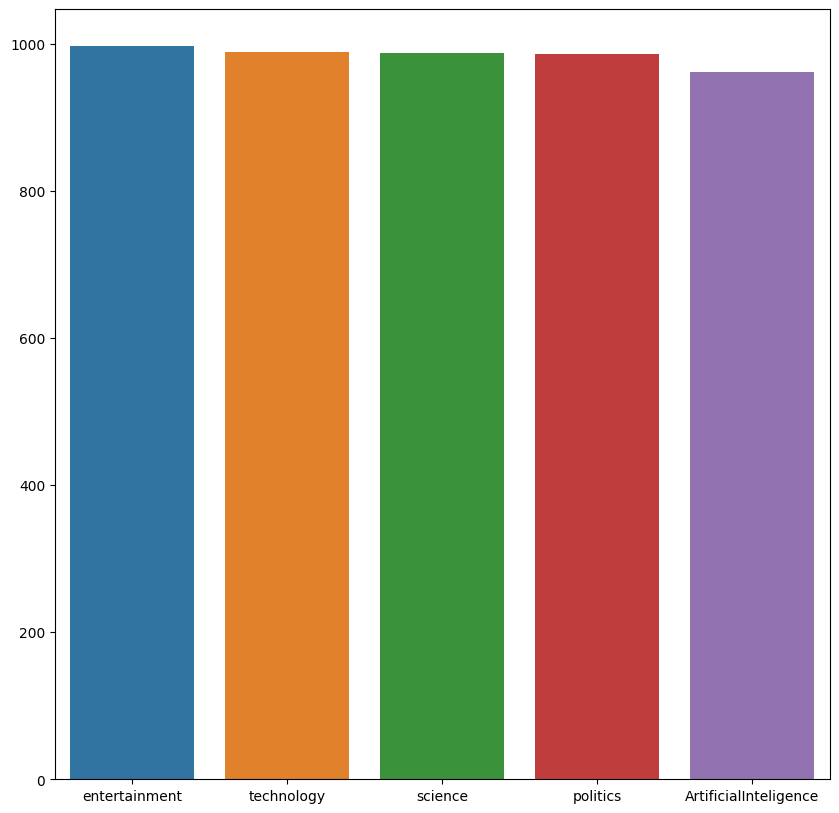

In [77]:
subreddit, counts = zip(*counter.most_common())
plt.figure(figsize = (10,10))
sns.barplot(x = list(subreddit), y = list(counts), hue = list(subreddit))
plt.show()

In [78]:
subreddits = df['subreddit'].unique().tolist()

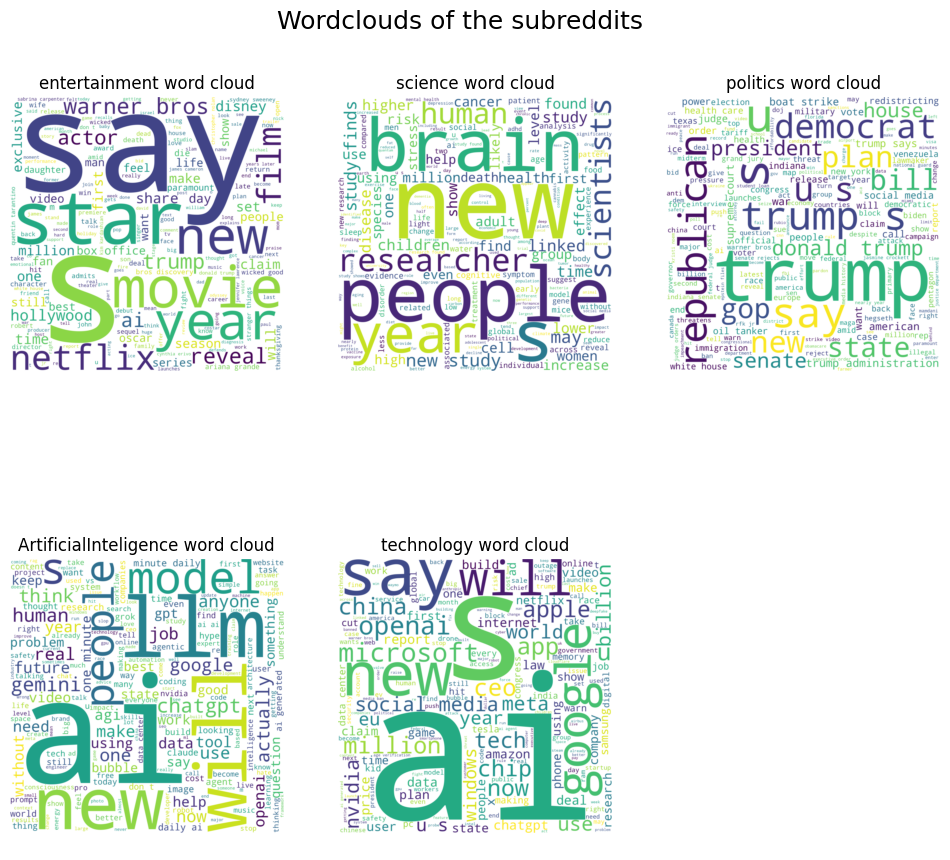

In [79]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Wordclouds of the subreddits", fontsize=18, y=0.95)

for sub, ax in zip(subreddits, axs.ravel()):
    stopwords = set(STOPWORDS)
    text = ' '.join(df[df['subreddit'] == sub]['title'].astype('str').tolist())
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stopwords)

    wordcloud = WordCloud(width=2000, height=2000, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"{sub} word cloud")
    ax.axis('off')

axs.ravel()[-1].axis('off')

plt.show()


In [80]:
def clean_text(text):
    stopwords = set(STOPWORDS)
    text = text.lower()

    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text)
    text = text.strip()
    text = re.sub(r"http\S+", "", text)
    return text


In [81]:
original_df = df.copy()
df['title'] = df['title'].map(clean_text)

In [82]:
print(original_df['title'][0])
print(df['title'][0])

Even the man behind ChatGPT, OpenAI CEO Sam Altman is worried about the ‘rate of change that’s happening in the world right now’ thanks to AI
even man behind chatgpt openai ceo sam altman worried rate change s happening world right now thanks ai


In [83]:
df = df.drop(columns = ['post_id'], axis = 1)
df = df.dropna()

In [84]:
class_to_index = {k:i for i, k in enumerate(subreddits)}
class_to_index

{'entertainment': 0,
 'science': 1,
 'politics': 2,
 'ArtificialInteligence': 3,
 'technology': 4}

In [85]:
num_classes = len(subreddits)

In [86]:
index_to_class = {v:k for k,v in class_to_index.items()}
index_to_class

{0: 'entertainment',
 1: 'science',
 2: 'politics',
 3: 'ArtificialInteligence',
 4: 'technology'}

In [87]:
def encode(indices, class_to_index):
    return [class_to_index[index] for index in indices]


In [88]:
encode(df.sample(5)["subreddit"].values, class_to_index=class_to_index)

[1, 0, 2, 1, 2]

In [89]:
df['subreddit'] = df['subreddit'].map(class_to_index)

In [90]:
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [91]:
decode(df.head()["subreddit"].values, index_to_class=index_to_class)

['entertainment', 'science', 'politics', 'science', 'ArtificialInteligence']

In [92]:
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)

In [93]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    encoded_inputs = tokenizer(batch['title'].tolist(), padding = 'longest',return_tensors = 'pt')
    return dict(ids=encoded_inputs["input_ids"], masks=encoded_inputs["attention_mask"], targets=np.array(batch["subreddit"]))

In [94]:
def preprocess(df, class_to_index:dict):
    df['title'] = df['title'].map(clean_text)
    df = df.drop(columns = ['post_id'], axis = 1)
    df = df.dropna()
    df['subreddit'] = df['subreddit'].map(class_to_index)
    outputs = tokenize(df)
    return outputs


In [95]:
train_inputs = preprocess(train_df, class_to_index)
val_inputs = preprocess(val_df, class_to_index)

In [96]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = True

In [97]:
ds = ray.data.read_parquet(DATASET_LOC)
ds = ds.random_shuffle(seed= 43)
ds.take(1)

2026-01-11 00:47:39,441	INFO progress_bar.py:213 -- === Ray Data Progress {Parquet dataset sampling} ===
2026-01-11 00:47:39,442	INFO progress_bar.py:215 -- Parquet dataset sampling: Progress Completed 1 / 1
2026-01-11 00:47:39,443	INFO parquet_datasource.py:1048 -- Estimated parquet encoding ratio is 1.475.
2026-01-11 00:47:39,443	INFO parquet_datasource.py:1108 -- Estimated parquet reader batch size at 1082402 rows
2026-01-11 00:47:40,105	INFO logging.py:397 -- Registered dataset logger for dataset dataset_2_0
2026-01-11 00:47:40,111	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_2_0. Full logs are in /tmp/ray/session_2026-01-11_00-46-52_612768_2932/logs/ray-data
2026-01-11 00:47:40,111	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_2_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2026-01-11 00:47:40,125	INFO progress_bar.py:213 -- === Ray Data Progress {ReadParqu

[{'post_id': '1og2tva',
  'title': 'Taxing red meat and sugary drinks while removing taxes on healthy foods could prevent 700 premature deaths a year and cut diet-related CO₂ emissions by 700,000 tonnes — all without raising grocery costs, study finds.',
  'subreddit': 'science'}]

In [98]:
train_ds, val_ds = ds.train_test_split(test_size = 0.2, seed = 43)

2026-01-11 00:47:41,577	INFO logging.py:397 -- Registered dataset logger for dataset dataset_3_0
2026-01-11 00:47:41,583	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_3_0. Full logs are in /tmp/ray/session_2026-01-11_00-46-52_612768_2932/logs/ray-data
2026-01-11 00:47:41,584	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_3_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle] -> TaskPoolMapOperator[Project] -> AggregateNumRows[AggregateNumRows]
2026-01-11 00:47:41,600	INFO progress_bar.py:213 -- === Ray Data Progress {ReadParquet->SplitBlocks(24)} ===
2026-01-11 00:47:41,601	INFO progress_bar.py:215 -- ReadParquet->SplitBlocks(24): Tasks: 1; Actors: 0; Queued blocks: 0 (0.0B); Resources: 1.0 CPU, 384.0MiB object store: Progress Completed 0 / ?
2026-01-11 00:47:41,602	INFO progress_bar.py:213 -- === Ray Data Progress {RandomShuffle} ===
2026-01-11 00:47:41,602	INFO progress_bar.py:215 -- RandomShuf

In [99]:
sample_ds = train_ds.map_batches(preprocess, batch_format = 'pandas', fn_kwargs = {'class_to_index' : class_to_index})

In [100]:
sample_ds.take(1)

2026-01-11 00:47:42,472	INFO logging.py:397 -- Registered dataset logger for dataset dataset_7_0
2026-01-11 00:47:42,475	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_7_0. Full logs are in /tmp/ray/session_2026-01-11_00-46-52_612768_2932/logs/ray-data
2026-01-11 00:47:42,476	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_7_0: InputDataBuffer[Input] -> LimitOperator[limit=1] -> TaskPoolMapOperator[MapBatches(preprocess)]
2026-01-11 00:47:42,498	INFO progress_bar.py:213 -- === Ray Data Progress {limit=1} ===
2026-01-11 00:47:42,499	INFO progress_bar.py:215 -- limit=1: Tasks: 0; Actors: 0; Queued blocks: 0 (0.0B); Resources: 0.0 CPU, 246.0B object store: Progress Completed 0 / ?
2026-01-11 00:47:42,501	INFO progress_bar.py:213 -- === Ray Data Progress {MapBatches(preprocess)} ===
2026-01-11 00:47:42,502	INFO progress_bar.py:215 -- MapBatches(preprocess): Tasks: 0; Actors: 0; Queued blocks: 0 (0.0B); Resources: 0.0 CPU, 0.0B object store: Prog

[{'ids': array([  102,  3764,   140,  1395, 12782, 10499, 30126, 25409, 10077,
         18342,  4093, 11107,  3363, 12778, 12462,  9267,   996,  3133,
          3463,  1482,   304,  8050, 12778,  8319, 13354,  6820,  1319,
         15933,   419,   736, 30126,  3266,   527, 11822,   103]),
  'masks': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'targets': 1}]

In [101]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [124]:
def load_dataset(num_samples = None):
    ds = ray.data.load_parquet(DATASET_LOC)
    ds = ds.random_shuffle(seed = 43)
    ds = ray.data.from_items(ds.take(num_samples) if num_samples else ds)
    return ds

In [103]:
class CustomPreprocessor(Preprocessor):
    def _fit(self, ds):
        subs = ds.unique(column = 'subreddit')
        self.class_to_index = {tag: i for i, tag in enumerate(subs)}
        self.index_to_class = {v:k for k, v in self.class_to_index.items()}
        return self
    def _transform_pandas(self, batch):
        return preprocess(batch, class_to_index = self.class_to_index)


In [104]:
llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
embedding_dim = llm.config.hidden_size

In [105]:
embedding_dim

768

In [106]:
text = ["Transfer learning with transformers for text classification.", "i hate ai. it really sucks", "man f this"]
batch = tokenizer(text, return_tensors="pt", padding="longest")
print(batch)
#batch = {k:torch.tensor(v) for k,v in batch.items()}
#print(batch)
result = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
seq, pool = result

{'input_ids': tensor([[  102,  2268,  1904,   190, 29155,   168,  3267,  2998,   205,   103,
             0],
        [  102,   259,  6500, 30107,  4725,   205,   256,  9695,  1639,   784,
           103],
        [  102,   508,   125,   238,   103,     0,     0,     0,     0,     0,
             0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])}


In [107]:
class FineTunedLLM(nn.Module):
    def __init__(self, llm_config, dropout_p, num_classes):
        super(FineTunedLLM, self).__init__()
        self.llm = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
        self.dropout_p = nn.Dropout(p=dropout_p)
        self.embedding_dim = llm_config.hidden_size
        self.fc1 = nn.Linear(self.embedding_dim, num_classes)

    def forward(self, batch):
        ids, masks = batch["ids"], batch["masks"]
        seq, pool = self.llm(input_ids=ids, attention_mask=masks)
        pool = self.dropout_p(pool)
        outputs = self.fc1(pool)
        return outputs

    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        z = self(batch)
        y_pred = torch.argmax(z, dim=1).cpu().numpy()
        return y_pred

    @torch.inference_mode()
    def predict_proba(self, batch):
        self.eval()
        z = self(batch)
        z = F.softmax(z, dim=1).cpu().numpy()
        return z

In [108]:
def load_data(num_samples=None):
    ds = ray.data.read_parquet(DATASET_LOC)
    ds = ds.random_shuffle(seed=1234)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [109]:
def pad_array(arrs, dtype = np.int32):
    max_len = max(len(arr) for arr in arrs)
    padded_arr = np.zeros((arrs.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arrs):
        padded_arr[i][:len(row)] = row
    return padded_arr


In [110]:
def collate_fn(batch):
    batch['ids'] = pad_array(batch['ids'])
    batch['masks'] = pad_array(batch['masks'])
    target_batch = {'ids' : torch.int32, 'masks' : torch.int32, 'targets' : torch.int32}
    tensor_batch = {}
    for key, item in batch.items():
        tensor_batch[key] = torch.as_tensor(item, dtype = target_batch[key])

    return tensor_batch

In [111]:
collate_fn(sample_ds.take_batch(batch_size = 128))

2026-01-11 00:47:51,355	INFO logging.py:397 -- Registered dataset logger for dataset dataset_8_0
2026-01-11 00:47:51,357	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_8_0. Full logs are in /tmp/ray/session_2026-01-11_00-46-52_612768_2932/logs/ray-data
2026-01-11 00:47:51,358	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_8_0: InputDataBuffer[Input] -> LimitOperator[limit=128] -> TaskPoolMapOperator[MapBatches(preprocess)]
2026-01-11 00:47:51,379	INFO progress_bar.py:213 -- === Ray Data Progress {limit=128} ===
2026-01-11 00:47:51,382	INFO progress_bar.py:215 -- limit=128: Tasks: 0; Actors: 0; Queued blocks: 0 (0.0B); Resources: 0.0 CPU, 16.8KiB object store: Progress Completed 0 / ?
2026-01-11 00:47:51,383	INFO progress_bar.py:213 -- === Ray Data Progress {MapBatches(preprocess)} ===
2026-01-11 00:47:51,383	INFO progress_bar.py:215 -- MapBatches(preprocess): Tasks: 0; Actors: 0; Queued blocks: 0 (0.0B); Resources: 0.0 CPU, 0.0B object stor

{'ids': tensor([[  102,  3764,   140,  ...,     0,     0,     0],
         [  102, 19510, 11258,  ...,     0,     0,     0],
         [  102,   881,  6161,  ...,     0,     0,     0],
         ...,
         [  102, 15679,  1074,  ...,     0,     0,     0],
         [  102,  1743,   157,  ...,     0,     0,     0],
         [  102,  2542, 17745,  ...,     0,     0,     0]], dtype=torch.int32),
 'masks': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32),
 'targets': tensor([1, 2, 4, 3, 1, 4, 4, 0, 3, 0, 2, 1, 4, 2, 4, 4, 0, 3, 1, 0, 3, 3, 0, 0,
         4, 3, 4, 3, 3, 4, 4, 2, 3, 3, 2, 1, 1, 2, 4, 3, 0, 0, 0, 4, 1, 0, 0, 2,
         1, 0, 3, 1, 1, 3, 0, 2, 1, 0, 2, 4, 4, 0, 1, 4, 2, 2, 2, 1, 0, 2, 1, 0,
         4, 1, 1, 3, 0, 1, 4, 4, 4, 2, 4, 1, 3, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 1,
         3, 1, 

In [126]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    model.train()
    loss = 0.0
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for i, batch in enumerate(ds_generator):
        optimizer.zero_grad()
        z = model(batch)
        targets = F.one_hot(batch["targets"].long(), num_classes=num_classes).float()
        losses = loss_fn(z, targets)
        losses.backward()
        optimizer.step()
        loss += (losses.detach().item() - loss) / (i + 1)
    return loss


In [127]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    model.eval()
    loss = 0.0
    y_trues, y_preds = [], []

    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)

    with torch.inference_mode():
        for i, batch in enumerate(ds_generator):
            z = model(batch)
            targets = F.one_hot(batch["targets"].long(), num_classes=num_classes).float()
            losses = loss_fn(z, targets)
            loss += (losses.detach().item() - loss) / (i + 1)

            # Get predictions
            y_pred = torch.argmax(z, dim=1).cpu().numpy()
            y_true = batch["targets"].cpu().numpy()

            y_trues.extend(y_true)
            y_preds.extend(y_pred)

    return loss, np.array(y_trues), np.array(y_preds)

In [137]:
def train_loop_per_worker(config):
    # Hyperparameters
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    # Get datasets
    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    # Model
    llm_base = BertModel.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
    model = FineTunedLLM(llm_config=llm_base.config, dropout_p=dropout_p, num_classes=num_classes)
    model = train.torch.prepare_model(model)
    del llm_base


    # Training components
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=lr_factor, patience=lr_patience
    )

    # Training
    context = train.get_context()
    batch_size_per_worker = batch_size // context.get_world_size()

    for epoch in range(num_epochs):
        # Train step
        train_loss = train_step(train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer)
        val_loss, y_true, y_pred = eval_step(val_ds, batch_size_per_worker, model, num_classes, loss_fn)
        scheduler.step(val_loss)
        # Calculate accuracy
        val_accuracy = accuracy_score(y_true, y_pred)


        # Report with accuracy
        metrics = dict(
            epoch=epoch,
            lr=optimizer.param_groups[0]["lr"],
            train_loss=train_loss,
            val_loss=val_loss,
            val_accuracy=val_accuracy
        )
        checkpoint = TorchCheckpoint.from_state_dict(model.state_dict())
        train.report(metrics, checkpoint=checkpoint)



In [138]:
train_loop_config = {
    "dropout_p": 0.5,
    "lr": 1e-4,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 10,
    "batch_size": 256,
    "num_classes": num_classes,
}

In [139]:
scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker,

)

In [140]:
# Run config
checkpoint_config = CheckpointConfig(num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min")
run_config = RunConfig(name="llm_with_acc", checkpoint_config=checkpoint_config, storage_path="~/ray_results")

In [141]:
ds = load_data()
train_ds, val_ds = ds.train_test_split(test_size = 0.2, seed = 43)

2026-01-11 01:08:37,304	INFO progress_bar.py:213 -- === Ray Data Progress {Parquet dataset sampling} ===
2026-01-11 01:08:37,305	INFO progress_bar.py:215 -- Parquet dataset sampling: Progress Completed 1 / 1
2026-01-11 01:08:37,306	INFO parquet_datasource.py:1048 -- Estimated parquet encoding ratio is 1.475.
2026-01-11 01:08:37,307	INFO parquet_datasource.py:1108 -- Estimated parquet reader batch size at 1082402 rows
2026-01-11 01:08:37,314	INFO logging.py:397 -- Registered dataset logger for dataset dataset_45_0
2026-01-11 01:08:37,318	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_45_0. Full logs are in /tmp/ray/session_2026-01-11_00-46-52_612768_2932/logs/ray-data
2026-01-11 01:08:37,319	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_45_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle] -> TaskPoolMapOperator[Project] -> AggregateNumRows[AggregateNumRows]
2026-01-11 01:08:37,331	INFO progress

In [142]:
preprocessor = CustomPreprocessor()
train_ds =  preprocessor.fit_transform(train_ds)
val_ds = preprocessor.transform(val_ds)
train_ds = train_ds.materialize()
val_ds = val_ds.materialize()

2026-01-11 01:08:38,480	INFO logging.py:397 -- Registered dataset logger for dataset dataset_49_0
2026-01-11 01:08:38,485	INFO hash_aggregate.py:180 -- Estimated memory requirement for aggregating aggregator (partitions=1, aggregators=1, dataset (estimate)=0.0GiB): shuffle=0.5MiB, output=0.5MiB, total=1.0MiB, 
2026-01-11 01:08:38,490	INFO streaming_executor.py:178 -- Starting execution of Dataset dataset_49_0. Full logs are in /tmp/ray/session_2026-01-11_00-46-52_612768_2932/logs/ray-data
2026-01-11 01:08:38,490	INFO streaming_executor.py:179 -- Execution plan of Dataset dataset_49_0: InputDataBuffer[Input] -> HashAggregateOperator[HashAggregate(key_columns=(), num_partitions=1)] -> LimitOperator[limit=1]
2026-01-11 01:08:38,646	INFO progress_bar.py:213 -- === Ray Data Progress {HashAggregate(key_columns=(), num_partitions=1)} ===
2026-01-11 01:08:38,651	INFO progress_bar.py:215 -- HashAggregate(key_columns=(), num_partitions=1): Tasks: 20; Actors: 0; Queued blocks: 0 (0.0B); Resources

In [143]:
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds}
)

In [144]:
results = trainer.fit()

In [145]:
results

Result(metrics={'epoch': 9, 'lr': 6.400000000000001e-05, 'train_loss': 0.02436964906519279, 'val_loss': 0.24013333395123482, 'val_accuracy': 0.8426395939086294}, checkpoint=Checkpoint(filesystem=local, path=/root/ray_results/llm_with_acc/checkpoint_2026-01-11_01-11-41.545162), error=None, path='/root/ray_results/llm_with_acc', metrics_dataframe=   epoch      lr  train_loss  val_loss  val_accuracy
0      1  0.0001    0.209015  0.193333       0.82335, best_checkpoints=[(Checkpoint(filesystem=local, path=/root/ray_results/llm_with_acc/checkpoint_2026-01-11_01-09-48.657313), {'epoch': 1, 'lr': 0.0001, 'train_loss': 0.20901469513773918, 'val_loss': 0.19333338737487793, 'val_accuracy': 0.8233502538071066})], _storage_filesystem=<pyarrow._fs.LocalFileSystem object at 0x78012cf43070>)

In [123]:
# Check your config
print(train_loop_config)
print(f"num_epochs: {train_loop_config.get('num_epochs')}")

{'dropout_p': 0.5, 'lr': 0.0001, 'lr_factor': 0.8, 'lr_patience': 3, 'num_epochs': 10, 'batch_size': 256, 'num_classes': 5}
num_epochs: 10
